In [1]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
import pandas as pd
# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('data/meshlab.stl',remove_duplicate_polygons=1,calculate_normals=False,)
import numpy as np

In [2]:
normals=pd.DataFrame(your_mesh.normals)
toplayer_polygons=pd.DataFrame(your_mesh.points[normals[normals[2]>0.01].index])
selected_polygons=np.array(toplayer_polygons)

def area(x1, y1, x2, y2, x3, y3): 
  
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1)  
                + x3 * (y1 - y2)) / 2.0) 
  
    
def isInside(x1, y1, x2, y2, x3, y3, x, y): 
    

    Area = 0.5 *(-y2*x3 + y1*(-x2 + x3) + x1*(y2 - y3) + x2*y3);
    s = 1/(2*Area)*(y1*x3 - x1*y3 + (y3 - y1)*x + (x1 - x3)*y);
    t = 1/(2*Area)*(x1*y2 - y1*x2 + (y1 - y2)*x + (x2 - x1)*y);
    if(s>=0 and t>=0 and (1-s-t)>=0):
        return True
    else:
        return False
    
    
def sign (x1, y1, x2, y2, x3, y3):
    return (x1- x3) * (y2 - y3) - (x2 - x3) * (y1 - y3);


def PointInTriangle (x1, y1, x2, y2, x3, y3, x, y): 


    d1 = sign(x,y, x1,y1,x2,y3);
    d2 = sign(x,y, x2,y2, x3,y3);
    d3 = sign(x,y, x3,y3, x1,y1);

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0);
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0);

    return not(has_neg and has_pos);
def pda(x,y,t):
    return sum(a*y+c*b+d*x<d*a+c*y+b*x for i in(0,1,2)for a,b,c,d in[t[i-1]+t[i]])%3<1
def threaded_function(cntr,x,y):
    for idx,_plgn in enumerate(selected_polygons):

        _x1,_y1,_z1,_x2,_y2,_z2,_x3,_y3,_z3=_plgn
        t=((_x1, _y1), (_x2, _y2), (_x3, _y3))
        if pda(x,y,t):
            #(PointInTriangle(_x1, _y1, _x2, _y2, _x3, _y3, x, y)):

            _pt=(x,y,np.mean([_z1,_z2,_z3]),your_mesh.normals[idx])
            point_grid[cntr]=(_pt)
            break#plt.plot(x,y,'b.')


In [3]:
from scipy.spatial import cKDTree
x1=selected_polygons[:,0]
x2=selected_polygons[:,3]
x3=selected_polygons[:,6]
y1=selected_polygons[:,1]
y2=selected_polygons[:,4]
y3=selected_polygons[:,7]
x_max=np.max([np.max(x1),np.max(x2),np.max(x3)])
y_max=np.max([np.max(y1),np.max(y2),np.max(y3)])
x_min=np.max([np.min(x1),np.min(x2),np.min(x3)])
y_min=np.max([np.min(y1),np.min(y2),np.min(y3)])
dx=0.11
num_x=int((x_max-x_min)//dx)
point_grid=[]#[None]*(int(num_x**2))
cntr=0
threads=[]
from threading import Thread

num_x=50
#grid=np.array(np.meshgrid(np.linspace(x_min, x_max,num_x).ravel(),np.linspace(y_min, y_max,num_x).ravel()))
#print(grid.shape)
#num_x=20
x=[]
y=[]
r=[]


pnt_row=[]#[None]*(int(num_x**2))
for idx,_plgn in enumerate(selected_polygons):

    _x1,_y1,_z1,_x2,_y2,_z2,_x3,_y3,_z3=_plgn
    c_x=(_x1+_x2+_x3)/3
    c_y=(_y1+_y2+_y3)/3
    
    d_1=(_y1-c_y)**2+(_x1-c_x)**2
    d_2=(_y2-c_y)**2+(_x2-c_x)**2
    d_3=(_y3-c_y)**2+(_x3-c_x)**2
    r.append(np.sqrt(np.max([d_1,d_2,d_3])))
    
    x.append(c_x)
    y.append(c_y)
grid=np.array(np.meshgrid(np.linspace(x_min, x_max,num_x).ravel(),np.linspace(y_min, y_max,num_x).ravel()))
data=np.array(list(zip(grid[0].ravel(),grid[1].ravel())))
tree=cKDTree(data)
#tree=cKDTree(np.array(list(zip(x,y))))
print(data.shape)
_pts=[]
for _i,(_x,_y,_r) in enumerate(zip(x,y,r)):
    for point in (tree.query_ball_point([_x,_y],_r)):
        
        _x1,_y1,_z1,_x2,_y2,_z2,_x3,_y3,_z3=selected_polygons[_i]
        if isInside(_x1, _y1, _x2, _y2, _x3, _y3, data[point][0], data[point][1]):
            _pts.append([data[point][0],data[point][1]])
_pts=np.array(_pts)

(2500, 2)


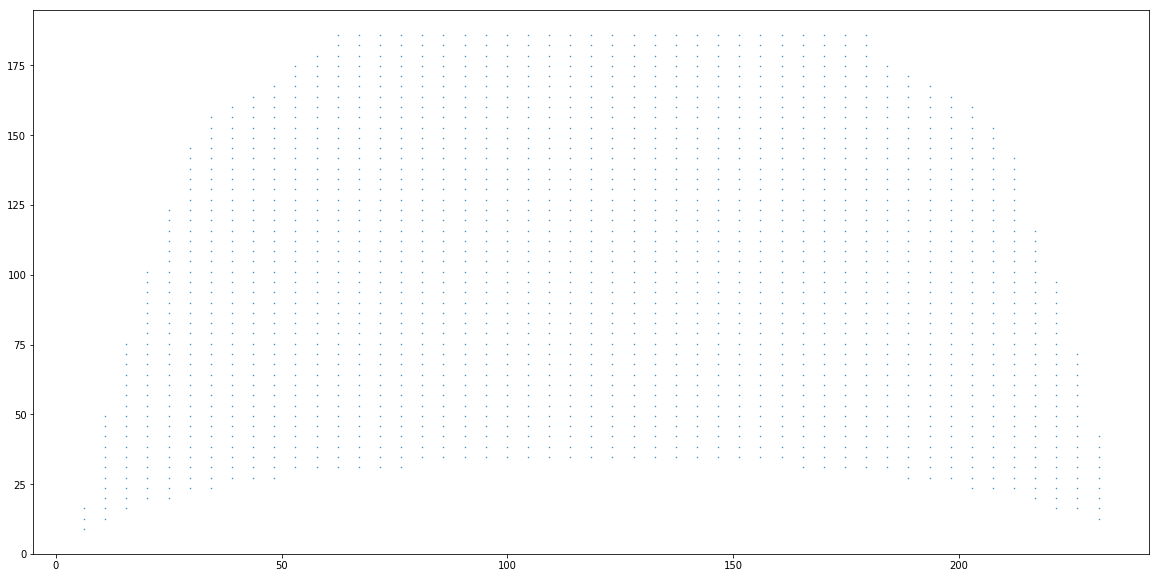

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

plt.scatter(_pts[:,0],_pts[:,1],s=0.2)

In [5]:
inner_tree=cKDTree(_pts)#.query([0,0])

In [6]:
_pts

array([[ 29.67064223,  34.7298257 ],
       [ 24.99084556,  23.66813426],
       [ 39.03023556,  64.22766954],
       ...,
       [184.10393222, 174.84458394],
       [184.10393222, 171.15735346],
       [188.78372889, 171.15735346]])

In [23]:
_pt=inner_tree.query([0,0])[1]
start_point=_pts[_pt]
dx=(x_max-x_min)/num_x
explored=[False]*len(_pts)
explored[_pt]=True
q=[start_point]

_x_tmp=[]
_y_tmp=[]
explored_sequence=[start_point]
# 1 means left and top
# 0 means left and bottom
direction=1

while len(q)>0:
    cur=q.pop()
    _x_tmp.append(cur[0])
    
    _y_tmp.append(cur[1])
    #print(cur)
    #plt.scatter(cur[0],cur[1])
    adj_pts=_pts[inner_tree.query_ball_point(cur,2*dx)]
    if direction:
        #minimize x
        # maximize y
        
        next_pt=adj_pts[(np.argmin(adj_pts[adj_pts[:,1]>cur[1]][:,0]))]
        q.append(next_pt)
    for _pt in inner_tree.query_ball_point(cur,2*dx):
        #print(_pt)
        pt=_pts[_pt]
        if(not explored[_pt]):
            explored[_pt]=True
            explored_sequence.append(pt)
            q.append(pt)
            break
            

KeyboardInterrupt: 

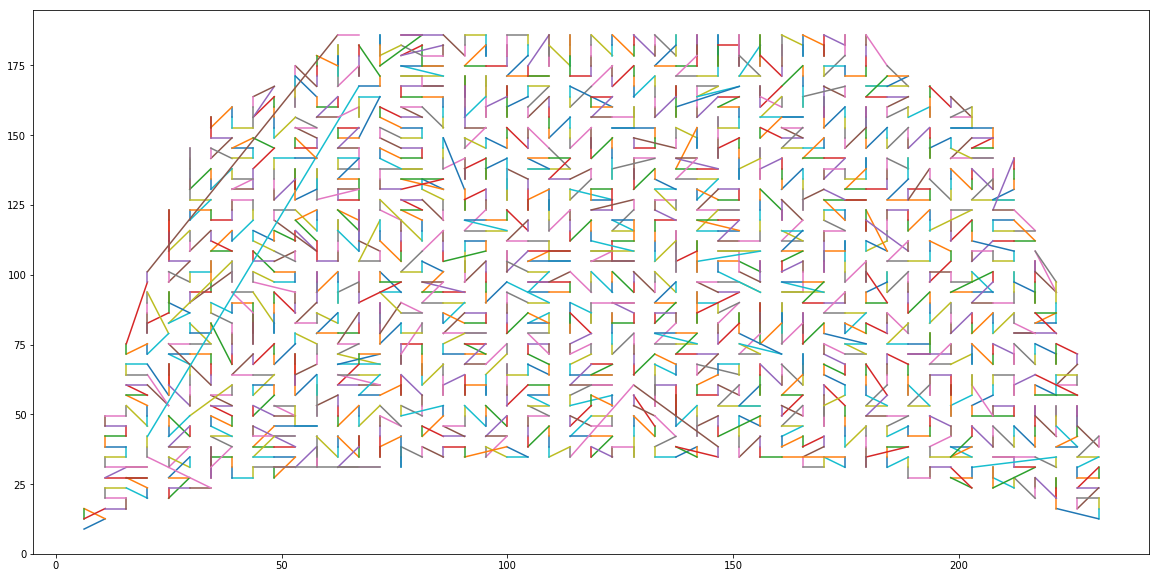

In [12]:
for idx in range(len(explored_sequence[:-1])):
    plt.plot([explored_sequence[idx][0],explored_sequence[idx+1][0]],[explored_sequence[idx][1],explored_sequence[idx+1][1]])
    

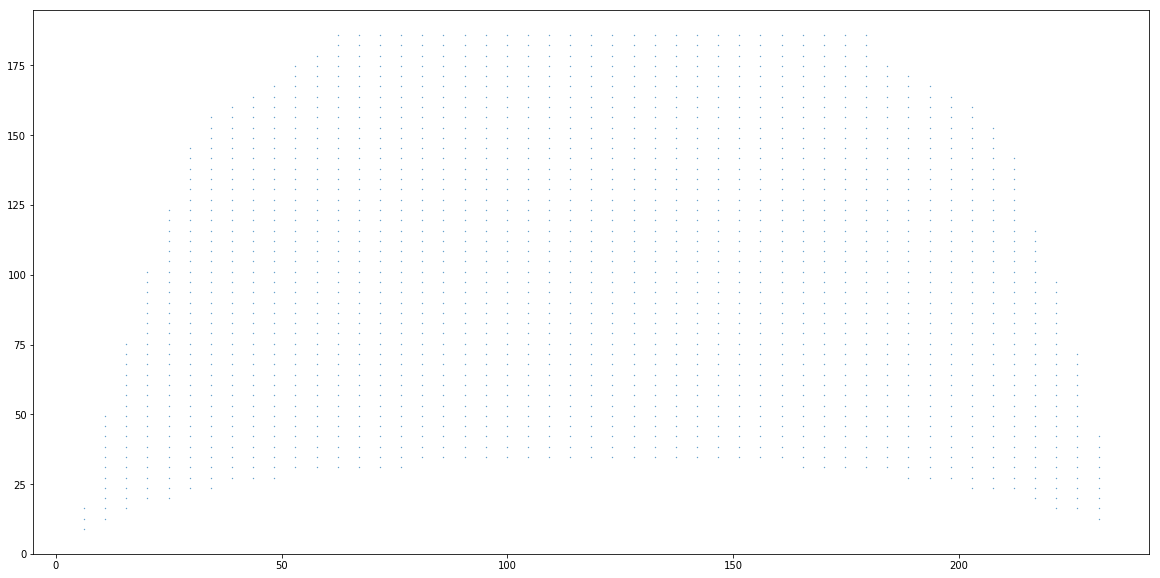

In [9]:
plt.scatter(_x_tmp,_y_tmp,s=0.1)